# Movie Classification

Oftentimes, we arbitrarily categorize things based on a general vibe. Is there anything more substantial to the subdivisions of movie eras beyond a general aesthetic? Can we reliably distinguish the eras of movie making based solely on the posters or movie stills? I want to explore the aesthetics of different movie eras while learning new tools like PyTorch and Python Image Library for image classification and exploration. 

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from collections import Counter

# used to convert genre id to name
import ast
import requests
from dotenv import load_dotenv

# for image exploration
from easyimages import EasyImageList
from PIL import Image

<h2><u>Data Exploration</u></h2>

<h3>Metadata</h3>

In [58]:
df = pd.read_csv('./data/metadata.csv')
df.head()

,filename,title,release_year,genres
0,346.jpg,Seven Samurai,1954,"[28, 18]"
1,567.jpg,Rear Window,1954,"[53, 9648]"
2,173.jpg,"20,000 Leagues Under the Sea",1954,"[12, 878, 10751]"
3,43332.jpg,Demetrius and the Gladiators,1954,"[12, 36, 18]"
4,10178.jpg,The Caine Mutiny,1954,"[18, 10752]"


In [59]:
# should be no invalid data because of the way we pulled it, but checking anyway
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6063 entries, 0 to 6062
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      6063 non-null   object
 1   title         6063 non-null   object
 2   release_year  6063 non-null   int64 
 3   genres        6063 non-null   object
dtypes: int64(1), object(3)
memory usage: 189.6+ KB


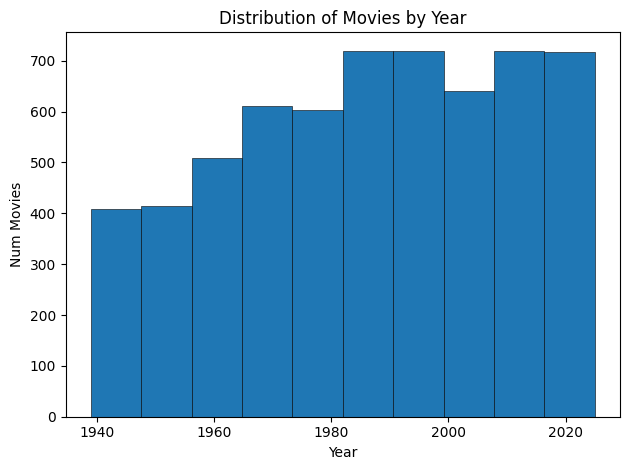

In [60]:
plt.hist(df['release_year'], edgecolor='black', linewidth=0.4)
plt.title("Distribution of Movies by Year")
plt.xlabel("Year")
plt.ylabel("Num Movies")
plt.tight_layout()
plt.show()

Kind of as expected, TMDB has much better capabilities for more recent and popular years, and some earlier years will have substantially less movies than later ones. We will try to account for this in our era subdivisions, but overall, we should be ok.

In [61]:
# Let's also make sure each entry in the csv has a corresponding image
res = []
for filename in df['filename']:
    if not os.path.exists(os.path.join("/Users/anubis/Desktop/Personal_Projects/movie-decade-classification/data/posters/", filename)):
        res.append(filename)
res

[]

##### Defining Film Eras:
Please check the <a href='https://github.com/Anubis-vc/movie-era-classification/blob/main/README.md'>README</a> for an in-depth discussion on how I chose these eras. As a reminder, I've attached the eras below:

1. *The Golden Age of Hollywood (1939 - 1949)*

2. *Post-War to New Hollywood Transition (1950 - 1966)*

3. *New Hollywood (1967 - 1982)*

4. *Blockbuster Era (1983 - 1994)*

5. *Indie and Digital Era (1995 - 2006)*

6. *Streaming and Superhero Era (2007 - 2017)*

7. *Modern Era/Post-Streaming (2018 - Current)* 

In [62]:
def find_era(year: int) -> str:
    if year < 1950:
        return "Golden Age"
    elif year < 1967:
        return "Post-War Transition"
    elif year < 1983:
        return "New Hollywood"
    elif year < 1995:
        return "Blockbuster Era"
    elif year < 2007:
        return "Digital Era"
    elif year < 2018:
        return "Franchise Era"
    else:
        return "Current Era"
    
df['temp'] = df['release_year'].apply(lambda x: find_era(x))
df['temp']

0       Post-War Transition
1       Post-War Transition
2       Post-War Transition
3       Post-War Transition
4       Post-War Transition
               ...         
6058            Current Era
6059            Current Era
6060            Current Era
6061            Current Era
6062            Current Era
Name: temp, Length: 6063, dtype: object

Though our dataset is small, it's good practice to vectorize data transformations for efficiency. I'm going to use the numpy select function though there is probably a way to do this in pure pandas I am unfamiliar with.

In [63]:
# clean up previous step
df.drop(columns=['temp'], inplace=True)

conditions = [
	df['release_year'] < 1950,
    df['release_year'] < 1967,
	df['release_year']< 1983,
 	df['release_year']< 1995,
    df['release_year']<  2007,
    df['release_year']< 2018
]

eras = ["Golden Age", "Post-War Transition", "New Hollywood", "Blockbuster Era", "Digital Era", "Franchise Era"]

df['era'] = np.select(conditions, eras, default="Current Era")
df


,filename,title,release_year,genres,era
0,346.jpg,Seven Samurai,1954,"[28, 18]",Post-War Transition
1,567.jpg,Rear Window,1954,"[53, 9648]",Post-War Transition
2,173.jpg,"20,000 Leagues Under the Sea",1954,"[12, 878, 10751]",Post-War Transition
3,43332.jpg,Demetrius and the Gladiators,1954,"[12, 36, 18]",Post-War Transition
4,10178.jpg,The Caine Mutiny,1954,"[18, 10752]",Post-War Transition
...,...,...,...,...,...
6058,1301470.jpg,Go For Broke,2024,"[28, 80]",Current Era
6059,1115623.jpg,The Last Kumite,2024,"[28, 53]",Current Era
6060,1272440.jpg,Tiger Wolf Rabbit,2024,"[18, 80]",Current Era
6061,1273472.jpg,Honey Money Phony,2024,"[35, 10749]",Current Era


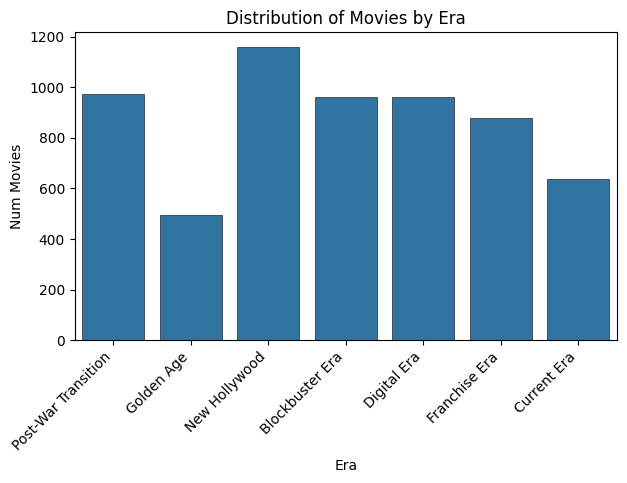

In [64]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x='era', edgecolor='black', linewidth=0.4)
plt.title("Distribution of Movies by Era")
plt.xlabel("Era")
plt.ylabel("Num Movies")
plt.xticks(rotation=45, ha='right')
plt.show()

In [65]:
era_to_int = {
    "Golden Age": 0,
    "Post-War Transition": 1,
    "New Hollywood": 2,
    "Blockbuster Era": 3,
    "Digital Era": 4,
    "Franchise Era": 5,
    "Current Era": 6
}

df['era_label'] = df['era'].map(era_to_int)
df

,filename,title,release_year,genres,era,era_label
0,346.jpg,Seven Samurai,1954,"[28, 18]",Post-War Transition,1
1,567.jpg,Rear Window,1954,"[53, 9648]",Post-War Transition,1
2,173.jpg,"20,000 Leagues Under the Sea",1954,"[12, 878, 10751]",Post-War Transition,1
3,43332.jpg,Demetrius and the Gladiators,1954,"[12, 36, 18]",Post-War Transition,1
4,10178.jpg,The Caine Mutiny,1954,"[18, 10752]",Post-War Transition,1
...,...,...,...,...,...,...
6058,1301470.jpg,Go For Broke,2024,"[28, 80]",Current Era,6
6059,1115623.jpg,The Last Kumite,2024,"[28, 53]",Current Era,6
6060,1272440.jpg,Tiger Wolf Rabbit,2024,"[18, 80]",Current Era,6
6061,1273472.jpg,Honey Money Phony,2024,"[35, 10749]",Current Era,6


In [66]:
# let's check for duplicate titles in case
df.sort_values(by='release_year')
duplicated = df.duplicated(subset=['title'])
print(np.sum(duplicated))

# by default, grabbing the latest duplicate title
latest_dups = df[duplicated]
latest_dups

154


,filename,title,release_year,genres,era,era_label
397,1426701.jpg,USSR Air Fleet Day,1949,[99],Golden Age,0
543,1426786.jpg,USSR Air Fleet Day,1951,[99],Post-War Transition,1
547,223.jpg,Rebecca,1940,"[9648, 10749, 53]",Golden Age,0
715,787118.jpg,Rope,1947,[],Golden Age,0
880,1484868.jpg,To Catch a Thief,1958,"[18, 80]",Post-War Transition,1
...,...,...,...,...,...,...
5845,337401.jpg,Mulan,2020,"[12, 14, 28]",Current Era,6
5942,646385.jpg,Scream,2022,"[27, 9648]",Current Era,6
5943,505026.jpg,Death on the Nile,2022,"[9648, 80, 53]",Current Era,6
6036,673593.jpg,Mean Girls,2024,[35],Current Era,6


It seems like these duplicates come from remakes sharing the same name. We can check this easily by taking a subset of title and year instead. Just for fun, let's also see when most of these remakes are from.

In [67]:
np.sum(df.duplicated(subset=['title', 'release_year']))

0

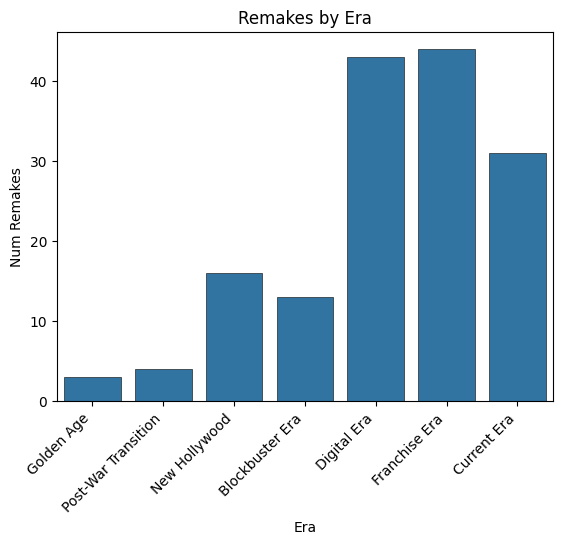

In [68]:
sns.countplot(data=latest_dups, x='era', edgecolor='black', linewidth=0.4)
plt.title("Remakes by Era")
plt.xlabel("Era")
plt.ylabel("Num Remakes")
plt.xticks(rotation=45, ha='right')
plt.show()

In [69]:
# since total counts are different, let's find proportions instead
era_order = df['era'].drop_duplicates().tolist()
era_counts = df['era'].value_counts().reindex(era_order)
remake_counts = latest_dups['era'].value_counts().reindex(era_order)

proportions = (remake_counts / era_counts)
proportions

era
Post-War Transition    0.004115
Golden Age             0.006061
New Hollywood          0.013805
Blockbuster Era        0.013542
Digital Era            0.044792
Franchise Era          0.050057
Current Era            0.048589
Name: count, dtype: float64

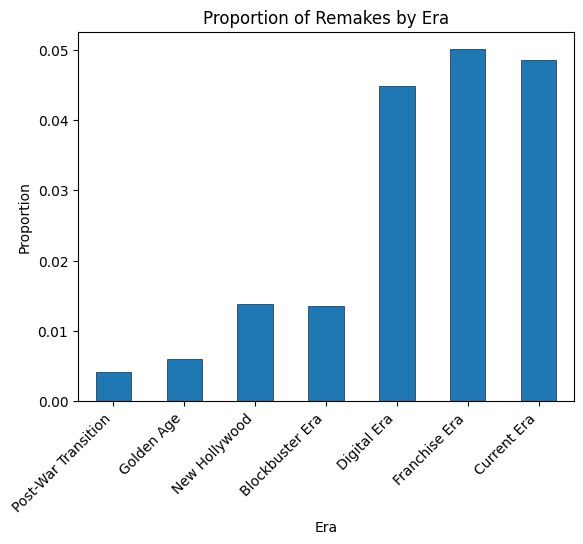

In [70]:
proportions.plot(kind='bar',
                 edgecolor='black',
                 linewidth=0.4,
                 xlabel='Era',
                 ylabel='Proportion',
                 title='Proportion of Remakes by Era')
plt.xticks(rotation=45, ha='right')
plt.show()

So clearly, the prevalence of remakes is something recent which does make sense: you have to have something to remake before you can remake it. That concludes some preliminary transformation of the metadata.

### Genres

Each movie currently contains a genre array with the multiclass classification of genre data from the TMDB API. As it stands, these labels mean nothing to anyone. Let's fix that and then explore the genre data.

In [71]:
df['genres'].dtype

dtype('O')

Pandas thinks the genre field is one big object because of the way our CSV Dictwriter converts the arrays to strings when it dumps them into the CSV. We can use the abstract syntax tree Python module to try and remedy this

In [72]:
# convert string reps to lists
df['genres'] = df['genres'].apply(ast.literal_eval)

In [73]:
# count emptys
empty_count = (df['genres'].str.len() == 0).sum()
print(empty_count)

311


In [74]:
remove_empty_genres = df[df['genres'].str.len() > 0]

In [75]:
load_dotenv()

def get_genre_mapping():
    url = "https://api.themoviedb.org/3/genre/movie/list?language=en"
    params = { "api_key": os.getenv("TMDB_API_KEY") }
    response = requests.get(url, params)
    
    if response.status_code == 200:
        genres = response.json().get('genres')
        return { genre['id']: genre['name'] for genre in genres }
    else:
        print(f"Failed to fetch genres: {response.status_code}")
        return {}
    
genre_mapping = get_genre_mapping()
print(genre_mapping)

{28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}


In [76]:
def genre_to_name(ids, map):
    return [map.get(genre_id) for genre_id in ids]

# to bypass SettingWithCopyWarning
remove_empty_genres2 = remove_empty_genres.copy()

remove_empty_genres.loc[:, 'genre_labels'] = remove_empty_genres2['genres'].apply(
    lambda x: genre_to_name(x, genre_mapping)
)
remove_empty_genres

/var/folders/vq/1vm3d1qd40dc31fh9jl7k1fc0000gn/T/ipykernel_10485/3868504984.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_empty_genres.loc[:, 'genre_labels'] = remove_empty_genres2['genres'].apply(


,filename,title,release_year,genres,era,era_label,genre_labels
0,346.jpg,Seven Samurai,1954,"[28, 18]",Post-War Transition,1,"[Action, Drama]"
1,567.jpg,Rear Window,1954,"[53, 9648]",Post-War Transition,1,"[Thriller, Mystery]"
2,173.jpg,"20,000 Leagues Under the Sea",1954,"[12, 878, 10751]",Post-War Transition,1,"[Adventure, Science Fiction, Family]"
3,43332.jpg,Demetrius and the Gladiators,1954,"[12, 36, 18]",Post-War Transition,1,"[Adventure, History, Drama]"
4,10178.jpg,The Caine Mutiny,1954,"[18, 10752]",Post-War Transition,1,"[Drama, War]"
...,...,...,...,...,...,...,...
6058,1301470.jpg,Go For Broke,2024,"[28, 80]",Current Era,6,"[Action, Crime]"
6059,1115623.jpg,The Last Kumite,2024,"[28, 53]",Current Era,6,"[Action, Thriller]"
6060,1272440.jpg,Tiger Wolf Rabbit,2024,"[18, 80]",Current Era,6,"[Drama, Crime]"
6061,1273472.jpg,Honey Money Phony,2024,"[35, 10749]",Current Era,6,"[Comedy, Romance]"


In [77]:
exploded = remove_empty_genres.explode('genre_labels')
dummies = pd.get_dummies(exploded['genre_labels'])
dummies_agrregated = dummies.groupby(exploded.index).sum()
genre_final = pd.concat([remove_empty_genres, dummies_agrregated], axis=1)
genre_final

,filename,title,release_year,genres,era,era_label,genre_labels,Action,Adventure,Animation,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,346.jpg,Seven Samurai,1954,"[28, 18]",Post-War Transition,1,"[Action, Drama]",1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,567.jpg,Rear Window,1954,"[53, 9648]",Post-War Transition,1,"[Thriller, Mystery]",0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,173.jpg,"20,000 Leagues Under the Sea",1954,"[12, 878, 10751]",Post-War Transition,1,"[Adventure, Science Fiction, Family]",0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,43332.jpg,Demetrius and the Gladiators,1954,"[12, 36, 18]",Post-War Transition,1,"[Adventure, History, Drama]",0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,10178.jpg,The Caine Mutiny,1954,"[18, 10752]",Post-War Transition,1,"[Drama, War]",0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6058,1301470.jpg,Go For Broke,2024,"[28, 80]",Current Era,6,"[Action, Crime]",1,0,0,...,0,0,0,0,0,0,0,0,0,0
6059,1115623.jpg,The Last Kumite,2024,"[28, 53]",Current Era,6,"[Action, Thriller]",1,0,0,...,0,0,0,0,0,0,0,1,0,0
6060,1272440.jpg,Tiger Wolf Rabbit,2024,"[18, 80]",Current Era,6,"[Drama, Crime]",0,0,0,...,0,0,0,0,0,0,0,0,0,0
6061,1273472.jpg,Honey Money Phony,2024,"[35, 10749]",Current Era,6,"[Comedy, Romance]",0,0,0,...,0,0,0,0,1,0,0,0,0,0


Let's explore and visualize some of this genre data as well

In [78]:
# find counts of all genres
all_genres = [genre for sublist in genre_final['genre_labels'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_counts = pd.DataFrame(genre_counts.items(), columns=['genres', 'count'])
genre_counts.sort_values(by='count', inplace=True, ascending=False)
print(genre_counts)


             genres  count
1             Drama   2330
11           Comedy   2069
0            Action   1454
4         Adventure   1243
2          Thriller   1170
10          Romance   1096
13            Crime    803
6            Family    687
5   Science Fiction    681
16          Fantasy    639
14           Horror    532
17        Animation    434
3           Mystery    423
7           History    287
9             Music    286
8               War    253
12          Western    166
15      Documentary    162
18         TV Movie     15


In [79]:
# calculate proprtions of each genre based on era to so numbers are compared evenly
def getProportionsByEra():
    era_data = {}
    
    for era in genre_final['era'].unique():
        era_movies = genre_final[genre_final['era'] == era]
        
        all_genres = []
        for genres in era_movies['genre_labels']:
            all_genres.extend(genres)
        
        # find genre counts, total genres, and proportions
        genres_by_era = Counter(all_genres)
        total_genre_instances = sum(genres_by_era.values())
        genre_proportions = {genre: count / total_genre_instances for genre, count in genres_by_era.items()}
        
        # add to dictionary
        era_data[era] = genre_proportions
    return era_data

era_proportions = getProportionsByEra()

for era, props in era_proportions.items():
    print(f"\n{era}:")
    top_genres = sorted(props.items(), key=lambda x: x[1], reverse=True)[:5]
    for genre, prop in top_genres:
        print(f"  {genre}: {prop:.1%}")
        
        


Post-War Transition:
  Drama: 24.4%
  Comedy: 12.8%
  Romance: 12.7%
  Adventure: 6.1%
  Music: 4.4%

Golden Age:
  Drama: 22.9%
  Romance: 14.3%
  Comedy: 11.9%
  Documentary: 6.2%
  Music: 5.3%

New Hollywood:
  Drama: 19.0%
  Comedy: 14.4%
  Action: 8.6%
  Thriller: 8.0%
  Adventure: 7.1%

Blockbuster Era:
  Comedy: 17.4%
  Drama: 15.9%
  Action: 10.2%
  Thriller: 9.1%
  Romance: 8.0%

Digital Era:
  Comedy: 14.7%
  Drama: 13.8%
  Action: 10.9%
  Thriller: 9.6%
  Adventure: 8.6%

Franchise Era:
  Action: 13.5%
  Comedy: 13.1%
  Adventure: 11.8%
  Drama: 11.0%
  Thriller: 8.2%

Current Era:
  Action: 14.1%
  Comedy: 11.4%
  Adventure: 11.2%
  Drama: 10.2%
  Thriller: 8.2%


Pretty cool! Dramas taper off as the era becomes more modern. People have less interest in the Melodramas of early Hollywood and the advent of CGI makes adventure and escapism much more appealing than ever before. Additionally, sutdios show more uniformity in more recent years. This is an interesting trend I would like to explore further in the future.

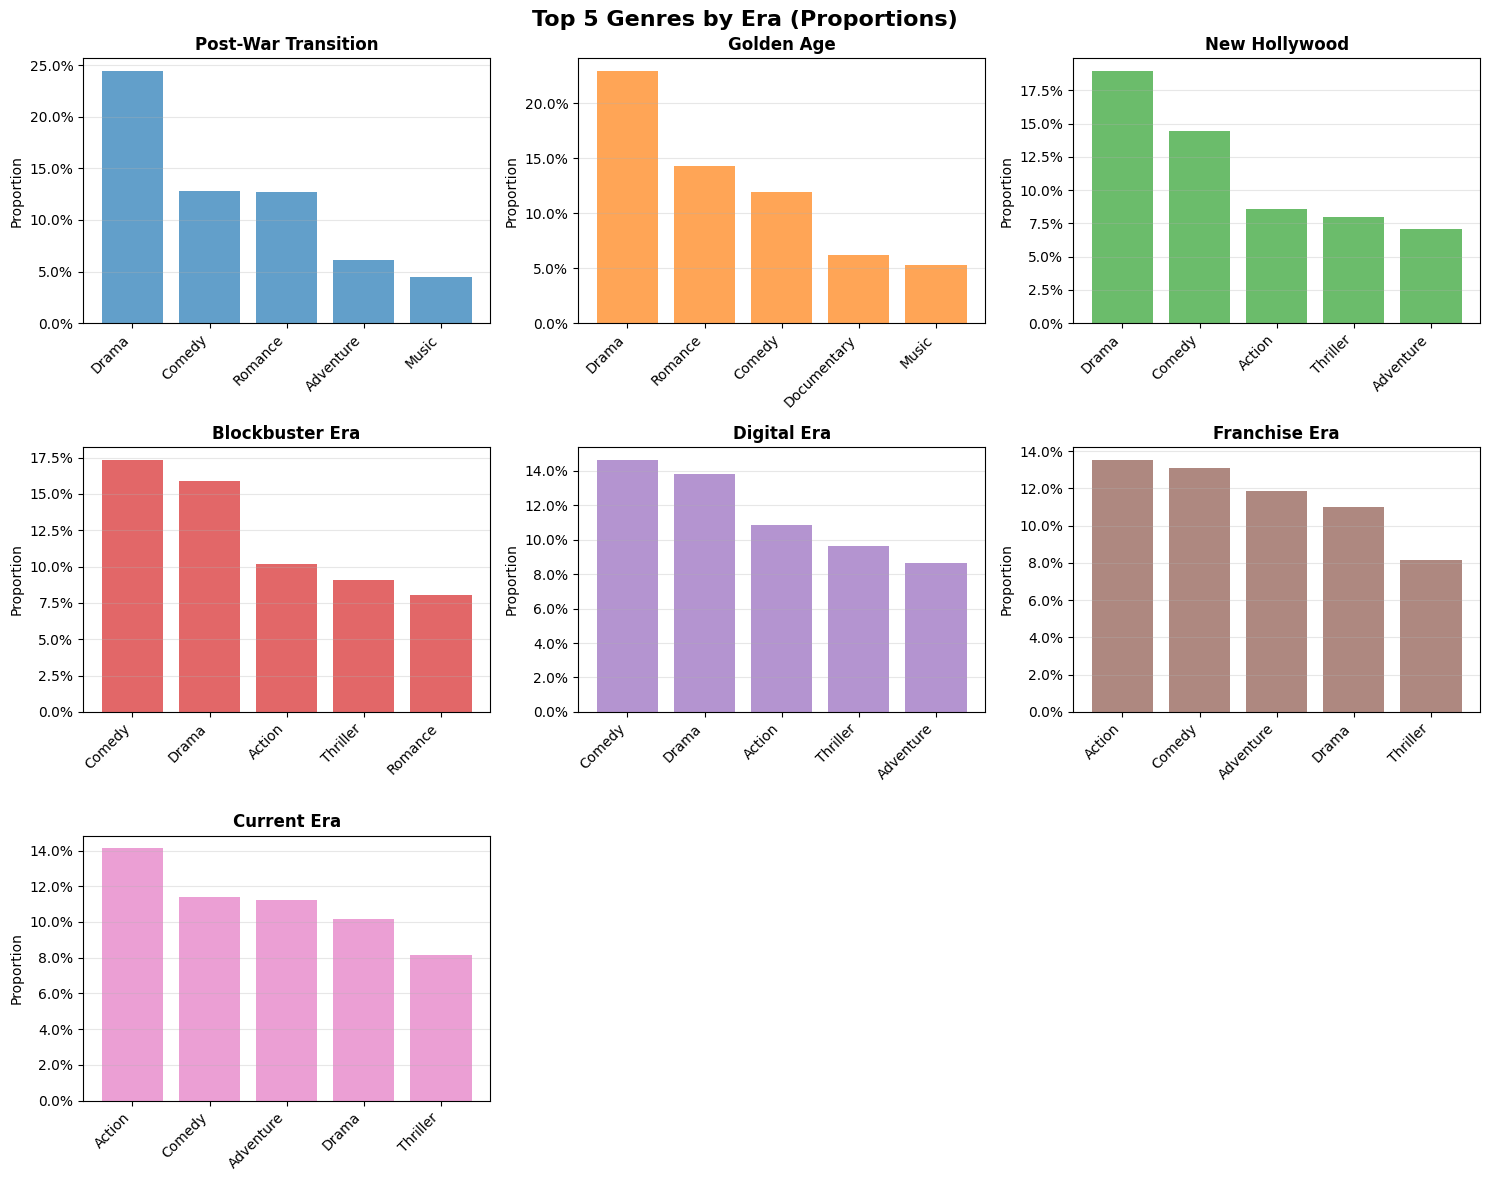

In [80]:
'''
Cell plots top genres for each era side by side in 3 rows
'''
era_top_genres = {}
for era, props in era_proportions.items():
    top_genres = sorted(props.items(), key=lambda x: x[1], reverse=True)[:5]
    era_top_genres[era] = top_genres

num_eras = len(era_top_genres)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

colors = plt.cm.tab10(range(num_eras))

for i, (era, top_genres) in enumerate(era_top_genres.items()):
    genres = [genre for genre, _ in top_genres]
    proportions = [prop for _, prop in top_genres]
    
    axes[i].bar(range(len(genres)), proportions, color=colors[i], alpha=0.7)
    axes[i].set_title(f'{era}', fontweight='bold')
    axes[i].set_xticks(range(len(genres)))
    axes[i].set_xticklabels(genres, rotation=45, ha='right')
    axes[i].set_ylabel('Proportion')
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    axes[i].grid(axis='y', alpha=0.3)

# Hide any unused subplots
for j in range(num_eras, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Top 5 Genres by Era (Proportions)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

<h3>Images</h3>

It's much easier to explore numerical/categorical data than it is images, but the set of images is our entire mapping domain, so it would be cursory to skip exploring the image data for our problem.

First, let's get a feel for the images in general; what do they look like and are there any obvious black screens or blurry images?

In [81]:
list = EasyImageList.from_folder('/Users/anubis/Desktop/Personal_Projects/movie-decade-classification/data/posters')
list.symlink_images()
list.html(sample=200)

Ok, pretty good! From this random sample, it looks like most of our images came out well. Looking at these images from here I'm having a hard time distinguishing either era or genre from any of the posters just looking at the images. Hopefully the network finds a better mapping.

Let's see what else we can find out, like the sizes of the images. TheMovieDatabase API documentation can be a little hard to parse for image data, so we can figure out the size manually for each poster. A really important new idea I came accross when exploring image data is anchor boxes. The best resource I found is <a href='https://d2l.ai/chapter_computer-vision/anchor.html'>here</a>, but I will summarize below.

Anchor boxes - Your neural network will sample different regions of your images to try and determine features of interest. The article above uses the term scale a lot, this is *not* the definition of scale used in photography. Instead, scale refers to the size of the anchor box as compared to the image. The network will produce many bounding boxes of different aspect ratios and sizes anchored at each pixel of the image. After a lot of trial an error, the network ideally figures out the perfect bounding boxes for the important features of your image. Usually, on image analysis you'll try to find the aspect ratio and area of these ideal bounding boxes for your image.

Luckily, our object is the entire image, so we can go ahead and do a raw analysis of the image dimensions.

In [82]:
poster_dir = '/Users/anubis/Desktop/Personal_Projects/movie-decade-classification/data/posters/'
img_dim_data = []

for img_name in os.listdir(path=poster_dir):
    img_path = os.path.join(poster_dir, img_name)
    with Image.open(img_path) as img:
        width, height = img.size
        aspect_ratio = width / height
        area = width * height
        img_dim_data.append({
            'name': img_name,
            'height': height,
            'width': width,
            'aspect_ratio': aspect_ratio,
            'area': area,
            'format': img.format,
            'mode': img.mode
        })

img_dims_df = pd.DataFrame(img_dim_data)
print(f"Total Images: {len(img_dims_df)}")
print(f"Unique dims: {len(img_dims_df[['height', 'width']].drop_duplicates())}")
print(f"Unique aspect ratios: {len(img_dims_df['aspect_ratio'].drop_duplicates())}")
print(f"Unique areas: {len(img_dims_df['area'].drop_duplicates())}\n")
print(img_dims_df[['height', 'width', 'aspect_ratio', 'area']].describe())

Total Images: 6063
Unique dims: 38
Unique aspect ratios: 38
Unique areas: 38

            height   width  aspect_ratio          area
count  6063.000000  6063.0   6063.000000   6063.000000
mean    230.219528   154.0      0.669121  35453.807356
std       3.758830     0.0      0.011934    578.859834
min     202.000000   154.0      0.626016  31108.000000
25%     231.000000   154.0      0.666667  35574.000000
50%     231.000000   154.0      0.666667  35574.000000
75%     231.000000   154.0      0.666667  35574.000000
max     246.000000   154.0      0.762376  37884.000000


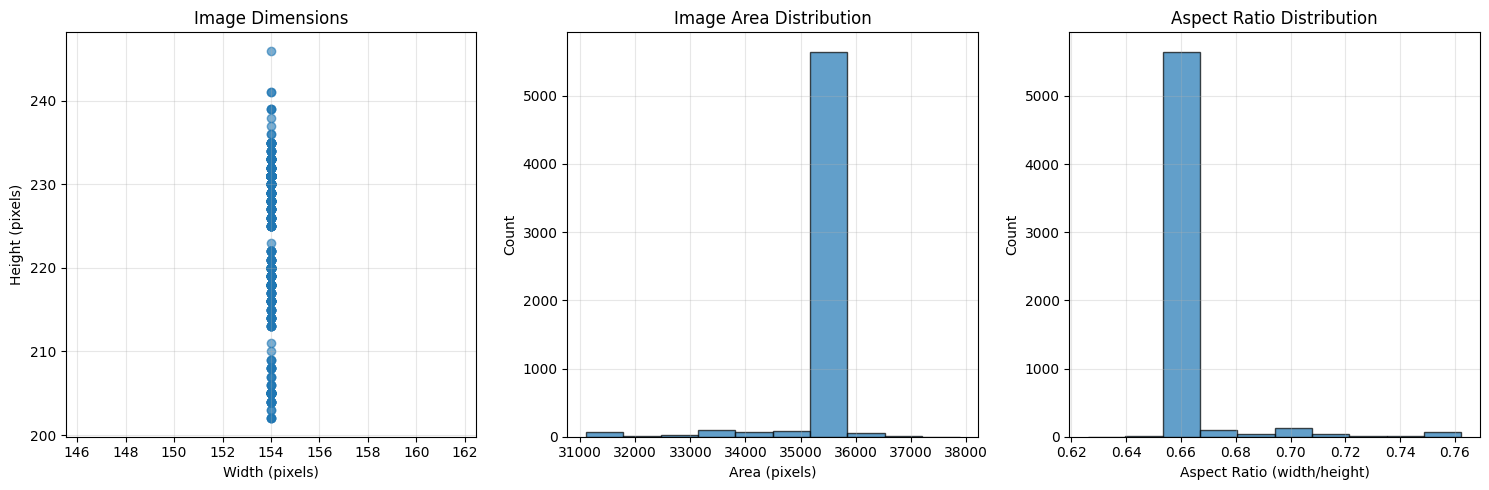

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# scatter plot for height vs. width
axes[0].scatter(img_dims_df['width'], img_dims_df['height'], alpha=0.6)
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Height (pixels)')
axes[0].set_title('Image Dimensions')
axes[0].grid(True, alpha=0.3)

# histogram for area
axes[1].hist(img_dims_df['area'], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Area (pixels)')
axes[1].set_ylabel('Count')
axes[1].set_title('Image Area Distribution')
axes[1].grid(True, alpha=0.3)

# histogram for aspect ratio
axes[2].hist(img_dims_df['aspect_ratio'], alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Aspect Ratio (width/height)')
axes[2].set_ylabel('Count')
axes[2].set_title('Aspect Ratio Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

So it looks like all the widths are the same with differing heights. The areas and aspect ratios have a few outliers we'll have to adjust before moving on so all our images are the same size. Let's do that now.

When I can, I will try to modify the images by cropping and adding padding such that the aspect ratio of the internal image stays the same, but the overall image changes aspect ratio for uniformity. This is called a non-destructive resize. Additionally, I want all my images to have the same pixel values. Since most of the posters are overwhelmingly of size 154x231, that's what I will use.

In [ ]:
# TODO: Color Distribution